## Задача:

    Используя метод линейной регрессии из библиотеки PyTorch
    решить задачу предсказания цены дома исходя из имеющей о нём информации.

In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.datasets
import matplotlib.pyplot as plt

from torch.autograd import Variable
from sklearn.model_selection import train_test_split

%matplotlib inline

    Посмотрим на наши данные.

In [2]:
houses = sklearn.datasets.fetch_california_housing('../data')
data = pd.DataFrame(houses.data, columns=houses.feature_names)
data = data.assign(Price = houses.target)
cols = list(data.columns)
cols.remove('Price')
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [3]:
print(houses.DESCR)

California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/datasets/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.




    Они представляют собой таблицу с информацией об объектах недвижимости в Калифорнии за 1990 год.

In [4]:
data.shape

(20640, 9)

    Всего в таблице 20640 объектов.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
MedInc        20640 non-null float64
HouseAge      20640 non-null float64
AveRooms      20640 non-null float64
AveBedrms     20640 non-null float64
Population    20640 non-null float64
AveOccup      20640 non-null float64
Latitude      20640 non-null float64
Longitude     20640 non-null float64
Price         20640 non-null float64
dtypes: float64(9)
memory usage: 1.4 MB


    8 объясняющих переменных и одна целевая — Price

In [6]:
target = 'Price'

In [7]:
std = data.describe().loc['mean':'std',:]
for col in houses.feature_names:
    data[col] = (data[col]-std[col]['mean'])/std[col]['std']

## О методе линейной регрессии

Будем использовать множественную линейную регрессию, т.к. работаем с несколькими признаками. 
В основе метода лежит предположение о том, что значение целевого признака является линейной функцией 
от нескольких переменных (плюс шум). И суть заключается в том, чтобы подобрать наилучшее приближение
такой функции. Подбор осуществляется изменением «весов» линейной модели,
оценка «наилучшости» — с помощью метрики, измеряющей расхождение между предсказанным и реальным
результатами.

Данные, которые мы будем получать из таблицы, носят название «объясняющих переменных». Мы не можем на них никак влиять, и можем лишь раздать им «веса» в соответствии с тем, какой вклад они вносят в результат. Обозначим их $x_1, x_2, \dots, x_p$. Пресловутые веса, меняя которые мы хотим достигнуть наилучшего приближения, обозначим $w_1, w_2, \dots, w_p$. Константная составляющая — $w_0$. Тогда общий вид функции будет таким: $ \widehat{y} = w_0 + w_1x_1 + w_2x_2 + \dots + w_px_p $. Добавим фиктивную переменную $ x_0 = 1 $ и перепишем функцию компактнее: $\large{ \widehat{y} = \sum_{i=0}^{p}{w_ix_i} = w^Tx}$, где $ x = (x_0, x_1, \dots, x_p) $.

Зададим модель следующим образом:

$ \Large{y = Xw + \epsilon} $

где $ w $ — вектор весов модели


$ X $ — матрица из $ n $ строк (наблюдений) и $ p + 1 $ столбцов <br>(p объясняющих переменных + $ x_0 = 1 $)

$ \epsilon $ — шум (неустранимая ошибка в наблюдениях)

Формула для объясняемого значения каждого отдельного наблюдения соответственно будет иметь такой вид:

$ \large{y_i = \sum_{j=0}^{p}{w_j X_{ij}} + \epsilon_i} $

На модель (а точнее на гипотезу о том, какой у нас шум) накладываются следующие ограничения (из теормы Гаусса-Маркова):
    
1. $ \Large{\mathbb{E}\epsilon_i=0, \, \forall i} $
2. $ \Large{\mathbb{D}\epsilon_i=\sigma^2 < \infty, \, \forall i} $
3. $ \Large{cov(\epsilon_i, \epsilon_j) = \mathbb{E}(\epsilon_i - \mathbb{E}\epsilon_i)(\epsilon_j - \mathbb{E}\epsilon_j) = 0, \, \forall i \neq j} $

Если они не выполняются, то линейной регрессией это уже не назовёшь.

Известны следующие метрики для линейных моделей, измеряющие «близость» к реальному результата, полученного в результате работы модели.

1. Mean Absolute Error (MAE or L1)
2. Mean Square Error (MSE or L2)
3. Huber Loss
4. Log-cosh Loss
5. Quantile Loss

Последние три являются являются достачно экзотичными и их использование может быть оправдано спецификой данных (много незначащих выбросов в данных, MSE к этому не слишком устойчива — правильный выбор параметра для Хьюбера поможет), выбором метода (log-cosh используют например при работе с XGBoost, потому  что обладает преимуществами предыдущей функции и кроме того дважды дифференцируема, что важно для алгоритмов) или же требуемым форматом ответа на задачу (например в квантильной регресии одноимённая функция потерь позволяет получать более точные предсказания границ интервалов, если остатки не распределены нормально или их дисперсия непостоянна).

Потому будем выбирать между L1 и L2.

Так выглядит формула для Mean Absolute Error:
    
$ \Large{MAE = \frac{\sum_{i=1}^{n}|y_i-\hat{y_i}|}{n}} $

Так — для Mean Square Error:

$ \Large{MSE = \frac{\sum_{i=1}^{n}(y_i-\hat{y_i})^2}{n}} $

Будем искать наилучшую оценку параметров модели в классе линейных и несмещенных оценок. Именно для этого мы требуем выполнения условий теормы Гаусса-Маркова. И поэтому будем минимизировать среднеквадратичную ошибку, т.к. в случае использования MAE условия теоремы выполняться уже не будут.

Решим аналитически оптимизационную задачу минимизации MSE:

$ \Large{L = \frac{\sum_{i=1}^{n}{(y_i-w^T x_i)}}{n} = \frac{||y-Xw||_2^2}{n} = \frac{(y-Xw)^T(y-Xw)}{n} } $

Дифференцируем:

$ \Large{\frac{\partial{L}}{\partial{w}}} = \frac{\partial{}}{\partial{w}} \frac{1}{n} \bigl(y^Ty-2y^TXw+w^TX^TXw\bigr) = \frac{1}{n} \bigl(-2X^Ty+2X^TXw\bigr) $

Приравниваем к нулю:

$ \Large{\frac{\partial{L}}{\partial{w}}} = 0 \Leftrightarrow X^TXW=X^Ty \Leftrightarrow w=\bigl(X^TX\bigr)^{-1}X^Ty$

В принципе, тот же самый результат можно получить, если использовать вероятностный подход — сделать предположение о том, что шум распределён нормально с нулевым матожиданием и дисперсией $ \sigma^2 $. Далее, пользуясь свойствами нормального распределения, расписать функцию плотности и максимизируя логарифм правдоподобия, получить тот же самый результат. Т.е. минимизация среднеквадратичной ошибки с описанными ограничениями на модель эквивалентна максимизации правдоподобия данных и это является следствием того факта, что ошибки распределены нормально. Если они распределены нормально. На модельной задаче это почти наверное так и есть, но проверить не помешает.

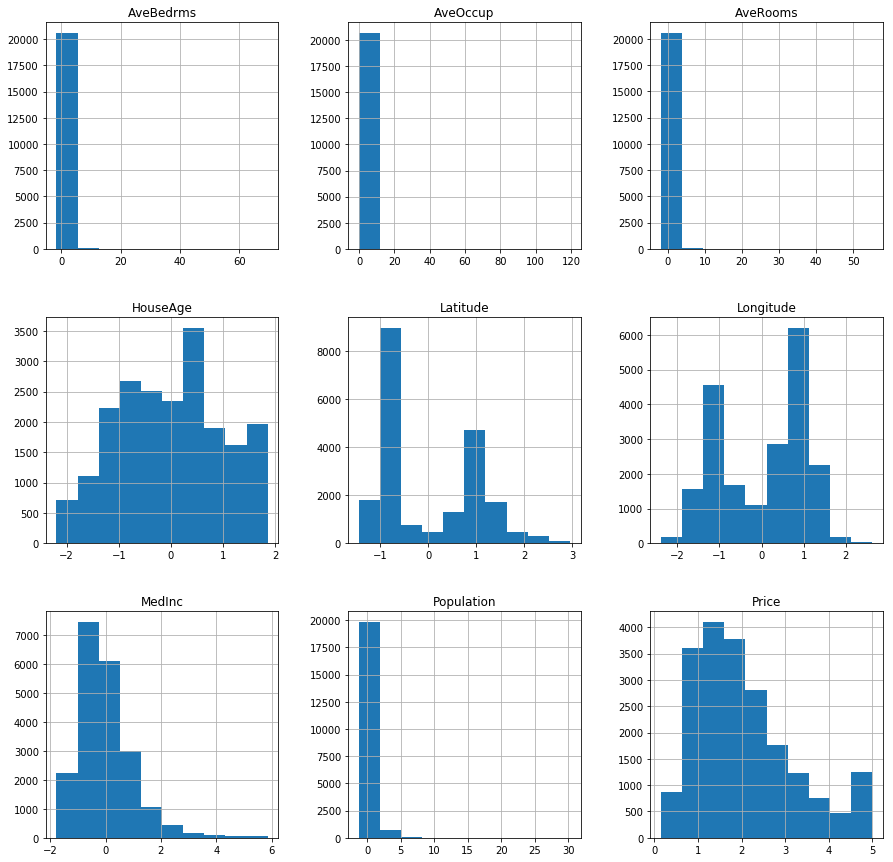

In [8]:
data.hist(figsize=(15,15));

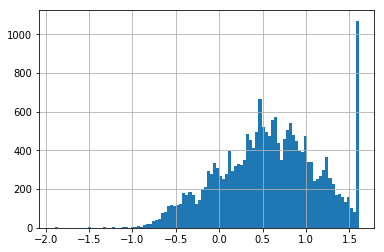

In [9]:
np.log(data.Price).hist(bins=100);

In [10]:
correlation_matrix = data.corr()
correlation_matrix

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967
Price,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000


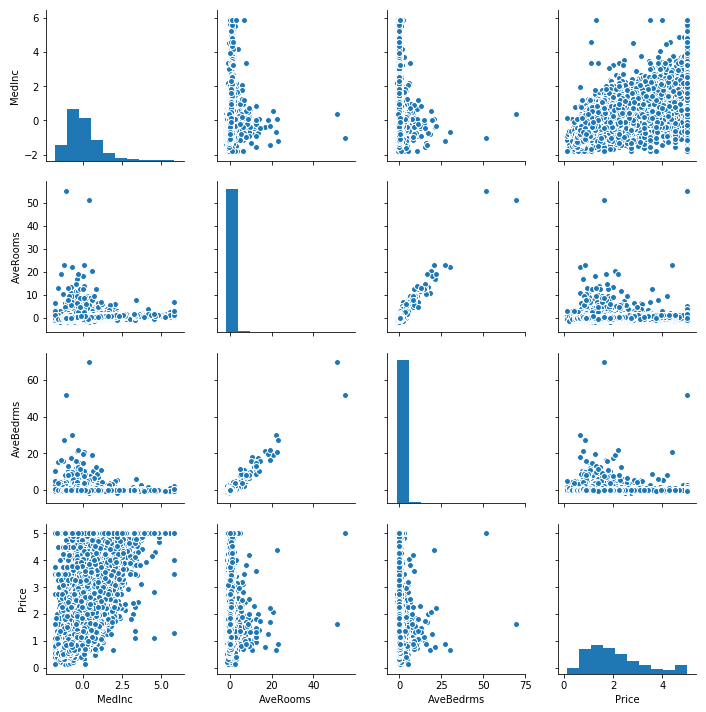

In [11]:
strong = 0.6
np.fill_diagonal(correlation_matrix.values, 0)
strongly_correlated = correlation_matrix.loc[lambda row: row.max() > strong].index
sns.pairplot(data[strongly_correlated]);